# 1) `ESML - Autolake-mapping` generates Azure ML Datasets + Feature engineering: `Bronze->Silver->Gold`

# USE CASE - Regression on CAR prices `car value regression model.`
- Scraped data of used cars listings. 100,000 listings, 
- Have been separated into files corresponding to each car manufacturer. 
- Collected the data to make a tool to predict how much you could sell your old car for compared to other stuff on the market
- Extended data set. 

######  NB! This,InteractiveLoginAuthentication, is only needed to run 1st time, then when ws_config is written, use later CELL in notebook, that just reads that file
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from azureml.core import Workspace
from azureml.core.authentication import InteractiveLoginAuthentication
#sys.path.append(os.path.abspath("../azure-enterprise-scale-ml/esml/common/"))  # NOQA: E402
from esml import ESMLDataset, ESMLProject

p = ESMLProject()
#p.dev_test_prod="dev"
auth = InteractiveLoginAuthentication(tenant_id = p.tenant)
ws, config_name = p.authenticate_workspace_and_write_config(auth)
######  NB!

In [1]:
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from esml import ESMLDataset, ESMLProject

p = ESMLProject() # Will search in ROOT for your copied SETTINGS folder '../../../settings', you should copy template settings from '../settings'
p.inference_mode = False
p.ws = p.get_workspace_from_config() #2) Load DEV or TEST or PROD Azure ML Studio workspace

p.active_model = 12 # Cars...price as label

unregister_all_datasets=False
if(unregister_all_datasets):
    p.unregister_all_datasets(p.ws) # For DEMO purpose

p.describe()

Using lake_settings.json with ESML version 1.4 - Models array support including LABEL


If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


Inference version: 1

 - ds01_vw
projects/project002/12_car_price_regression/train/ds01_vw/in/dev/2021/01/01/
projects/project002/12_car_price_regression/train/ds01_vw/out/bronze/dev/
projects/project002/12_car_price_regression/train/ds01_vw/out/silver/dev/

 - ds02_audi
projects/project002/12_car_price_regression/train/ds02_audi/in/dev/2021/01/01/
projects/project002/12_car_price_regression/train/ds02_audi/out/bronze/dev/
projects/project002/12_car_price_regression/train/ds02_audi/out/silver/dev/

 - ds03_bmw
projects/project002/12_car_price_regression/train/ds03_bmw/in/dev/2021/01/01/
projects/project002/12_car_price_regression/train/ds03_bmw/out/bronze/dev/
projects/project002/12_car_price_regression/train/ds03_bmw/out/silver/dev/
 

Training GOLD (p.GoldPath)
projects/project002/12_car_price_regression/train/gold/dev/
 

[A) USAGE]: to_score_folder, scored_folder, date_folder = p.get_gold_scored_unique_path()
A)INFERENCE ONLINE: GOLD to score (example if realtime - today)
projects/

In [5]:
def before_feature_engieering():
    p.connect_to_lake()
    esml_dataset = p.DatasetByName("ds01_vw") # Get dataset
    df_bronze = esml_dataset.InData.to_pandas_dataframe()
    return df_bronze
before_feature_engieering().head()

Using GEN2 as Datastore


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,T-Roc,2019,25000,Automatic,13904,Diesel,145,49.6,2.0
1,T-Roc,2019,26883,Automatic,4562,Diesel,145,49.6,2.0
2,T-Roc,2019,20000,Manual,7414,Diesel,145,50.4,2.0
3,T-Roc,2019,33492,Automatic,4825,Petrol,145,32.5,2.0
4,T-Roc,2019,22900,Semi-Auto,6500,Petrol,150,39.8,1.5


In [8]:
def test_feature_engieering():
    # Feture engineering: Bronze 2 Gold - working with Azure ML Datasets with Bronze, Silver, Gold concept
    esml_dataset = p.DatasetByName("ds01_vw") # Get dataset
    df_bronze = esml_dataset.Bronze.to_pandas_dataframe()
    p.save_silver(esml_dataset,df_bronze) #Bronze -> Silver

    df = esml_dataset.Silver.to_pandas_dataframe() 
    df_filtered = df[df.mileage < 10000] 
    gold = p.save_gold(df_filtered)  #Silver -> Gold
    return gold

In [9]:
datastore = None
gold = None
gold_train = None
try:
    datastore = p.connect_to_lake()
    gold = p.Gold
    gold_train = p.GoldTrain
    gold_train.name
    print("Not 1st time. We have data mapped already. Now connected to LAKE")
except: # If 1st time....no Gold exists, nor any mapping
    print("1st time. Lets init, map what data we have in LAKE, as Azure ML Datasets")
    datastore = p.init() # 3) Automapping from datalake to Azure ML datasets
    gold = test_feature_engieering()

Using GEN2 as Datastore
1st time. Lets init, map what data we have in LAKE, as Azure ML Datasets
...
Using GEN2 as Datastore
Searching for setting in ESML datalake...
ESML in-folder settings override = FALSE. [active_in_folder.json,active_scoring_in_folder.json] not found. 
 - Using [active_in_folder.json,active_scoring_in_folder.json] from ArgParse or GIT. No override from datalake settings

Inference mode (False = Training mode): False
Load data as Datasets....
ds01_vw
ds02_audi
ds03_bmw

####### Automap & Autoregister - SUCCESS!
1) Auto mapped 3 ESML Dataset with registered Azure ML Datasets (potentially all 3: IN,BRONZE, SILVER) in Datastore project002 

Dataset 'ds01_vw' status:
 - IN_Folder_has_files
 - BRONZE_Folder_has_files
 - SILVER_Folder_has_files
Dataset 'ds02_audi' status:
 - IN_Folder_has_files
 - BRONZE_Folder_has_files
 - SILVER_Folder_has_files
Dataset 'ds03_bmw' status:
 - IN_Folder_has_files
 - BRONZE_Folder_has_files
 - SILVER_Folder_has_files

2) Registered each D

In [10]:
gold.to_pandas_dataframe()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,T-Roc,2019,26883,Automatic,4562,Diesel,145,49.6,2.0
1,T-Roc,2019,20000,Manual,7414,Diesel,145,50.4,2.0
2,T-Roc,2019,33492,Automatic,4825,Petrol,145,32.5,2.0
3,T-Roc,2019,22900,Semi-Auto,6500,Petrol,150,39.8,1.5
4,T-Roc,2020,31895,Manual,10,Petrol,145,42.2,1.5
...,...,...,...,...,...,...,...,...,...
5405,California,2019,57991,Automatic,7486,Diesel,260,33.2,2.0
5406,Caddy Life,2020,22000,Manual,1700,Diesel,150,51.4,2.0
5407,Caddy Life,2020,16995,Manual,1724,Diesel,145,47.9,2.0
5408,Caddy Life,2019,17995,Manual,2156,Diesel,150,51.4,2.0


## SUMMARY - step 1
- ESML has now `Automap` and `Autoregister` Azure ML Datasets as: `IN, SILVER, BRONZE, GOLD`
- ESML has read configuration for correct environment (DEV, TEST, PROD). 
    - Both small customers, and large Enterprise customers often wants:  DEV, TEST, PROD in `diffferent Azure ML workspaces` (and different subscriptions)
- User has done feature engineering, and saved GOLD `p.save_gold`

# 2) `ESML` Train model in `5 codelines`

In [17]:
p.get_automl_performance_config() # 1)Get config, for active environment (dev,test or prod)

Loading AutoML config settings from: dev


{'enable_voting_ensemble': True,
 'enable_stack_ensemble': False,
 'model_explainability': True,
 'experiment_timeout_hours': 0.75,
 'iteration_timeout_minutes': 5,
 'n_cross_validations': 3,
 'enable_early_stopping': False,
 'iterations': 20,
 'max_cores_per_iteration': -1,
 'allowed_models': ['LightGBM',
  'AveragedPerceptronClassifier',
  'RandomForest',
  'Xgboost'],
 'path': '.',
 'debug_log': 'azure_automl_debug_dev.log'}

In [18]:
from esml import ESMLDataset, ESMLProject
from baselayer_azure_ml import AutoMLFactory,azure_metric_regression,azure_metric_classification
from azureml.train.automl import AutoMLConfig

automl_performance_config = p.get_automl_performance_config() # 1)Get config, for active environment (dev,test or prod)
aml_compute = p.get_training_aml_compute(p.ws) # 2)Get compute, for active environment

label = p.active_model["label"]
train_6, validate_set_2, test_set_2 = p.split_gold_3(0.6,label) # 3) Auto-registerin AZURE (M03_GOLD_TRAIN | M03_GOLD_VALIDATE | M03_GOLD_TEST)          # Alt: p.Gold.random_split(percentage=0.8, seed=23)

automl_config = AutoMLConfig(task = 'regression', # 4) Override the ENV config, for model(that inhertits from enterprise DEV_TEST_PROD config baseline)
                            primary_metric = azure_metric_regression.MAE, # # Note: Regression(MAPE) are not possible in AutoML
                            compute_target = aml_compute,
                            training_data = p.GoldTrain, # is 'train_6' pandas dataframe, but as an Azure ML Dataset
                            experiment_exit_score = '0.9', # DEMO purpose
                            label_column_name = label,
                            **automl_performance_config
                        )
via_pipeline = False
# Consistent/same return values from both AutoML ALTERNATIVES (run or pipeline)
best_run, fitted_model, experiment = AutoMLFactory(p).train_pipeline(automl_config) if via_pipeline else AutoMLFactory(p).train_as_run(automl_config)

Loading AutoML config settings from: dev
Using a model specific cluster, per configuration in project specific settings, (the integer of 'model_number' is the base for the name)
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Found existing cluster prj02-m12-dev for project and environment, using it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
image_build_compute = prj02-m12-dev
Experiment name: 12_car_price_regression
Azure ML Studio Workspace: msft-weu-DEV-eap-proj02_ai-amls
Start training run...
Submitting remote run.
No run_configuration provided, running on prj02-m12-dev with default configuration
Running on remote compute: prj02-m12-dev


Experiment,Id,Type,Status,Details Page,Docs Page
12_car_price_regression,AutoML_b608482b-eaf3-4398-b7f0-2b6001566e27,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation



Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

****************************************************************************************************

TYPE:         High cardinality feature detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and no high cardinality features were detected.
              Learn more about high cardinality feature h

Package:azureml-automl-runtime, training version:1.34.0.post1, current version:1.26.0
Package:azureml-core, training version:1.34.0, current version:1.26.0
Package:azureml-dataprep, training version:2.22.2, current version:2.13.2
Package:azureml-dataprep-native, training version:38.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.20.2, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.34.0, current version:1.26.0
Package:azureml-defaults, training version:1.34.0, current version:1.26.0
Package:azureml-interpret, training version:1.34.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.34.0, current version:1.26.0
Package:azureml-telemetry, training version:1.34.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.34.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.34.0.post1, current version:1.26.0
Package:azureml-mlflow, training version:1.34.0


Run(Experiment: 12_car_price_regression,
Id: AutoML_b608482b-eaf3-4398-b7f0-2b6001566e27_0,
Type: azureml.scriptrun,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
                                     steps=[('datatransformer',
                                             DataTransformer(enable_dnn=None,
                                                             enable_feature_sweeping=None,
                                                             feature_sweeping_config=None,
                                                             feature_sweeping_timeout=None,
                                                             featurization_config=None,
                                                             force_text_dnn=None,
                                                             is_cross_validation=None,
                                                             is_onnx_compatible=None,
                                                       

In [19]:
from baselayer_azure_ml import AutoMLFactory
target_env = p.dev_test_prod #"dev", test, prod  = Target environment. Does Model A score better than Model B?
print("SCORING DRIFT: If new model scores better in DEV (new data, or new code), we can promote this to TEST & PROD \n")

promote, m1_name, r1_id, m2_name, r2_run_id = AutoMLFactory(p).compare_scoring_current_vs_new_model(target_env)

if (promote and p.dev_test_prod == target_env): # Can register a model in same workspace (test->test) - need to retrain if going from dev->test (but copy from test->prod) AutoML7d5ab21270
    AutoMLFactory(p).register_active_model(target_env)


SCORING DRIFT: If new model scores better in DEV (new data, or new code), we can promote this to TEST & PROD 

Loading AutoML config settings from: dev
targe=source environement. Compare model version in DEV/TEST/PROD with latest registered in same DEV/TEST/PROD workspace (same workspace & subscriptiom comparison)



Package:azureml-automl-runtime, training version:1.34.0.post1, current version:1.26.0
Package:azureml-core, training version:1.34.0, current version:1.26.0
Package:azureml-dataprep, training version:2.22.2, current version:2.13.2
Package:azureml-dataprep-native, training version:38.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.20.2, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.34.0, current version:1.26.0
Package:azureml-defaults, training version:1.34.0, current version:1.26.0
Package:azureml-interpret, training version:1.34.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.34.0, current version:1.26.0
Package:azureml-telemetry, training version:1.34.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.34.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.34.0.post1, current version:1.26.0
Package:azureml-mlflow, training version:1.34.0


TARGET is in the same Azure ML Studio workspace as SOURCE, comparing with latest registered model...
target_best_run_id AutoML_697a7e02-3624-435e-9bc2-5a24b5dd8725


Package:azureml-automl-runtime, training version:1.34.0.post1, current version:1.26.0
Package:azureml-core, training version:1.34.0, current version:1.26.0
Package:azureml-dataprep, training version:2.22.2, current version:2.13.2
Package:azureml-dataprep-native, training version:38.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.20.2, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.34.0, current version:1.26.0
Package:azureml-defaults, training version:1.34.0, current version:1.26.0
Package:azureml-interpret, training version:1.34.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.34.0, current version:1.26.0
Package:azureml-telemetry, training version:1.34.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.34.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.34.0.post1, current version:1.26.0
Package:azureml-mlflow, training version:1.34.0


New trained model & cached RUN, has TASK_TYPE: regression and Best_Run_id: AutoML_b608482b-eaf3-4398-b7f0-2b6001566e27_0
Target model & RUN, in Azure ML Studio workspace to compare with, has TASK_TYPE: regression and Best_Run_id: 
This is the first model. No target to compare with, hence we will PROMOTE
Loading AutoML config settings from: dev
Loading AutoML config settings from: dev


model.version 1
Model name AutoMLb608482be0 is registered.


# TEST SET SCORING

In [8]:
#p.init()
#train_6, validate_set_2, test_set_2 = p.split_gold_3(0.6,"price") 

found model via REMOTE FILTER: Experiment TAGS: model name and version


Package:azureml-automl-runtime, training version:1.34.0.post1, current version:1.26.0
Package:azureml-core, training version:1.34.0, current version:1.26.0
Package:azureml-dataprep, training version:2.22.2, current version:2.13.2
Package:azureml-dataprep-native, training version:38.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.20.2, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.34.0, current version:1.26.0
Package:azureml-defaults, training version:1.34.0, current version:1.26.0
Package:azureml-interpret, training version:1.34.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.34.0, current version:1.26.0
Package:azureml-telemetry, training version:1.34.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.34.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.34.0.post1, current version:1.26.0
Package:azureml-mlflow, training version:1.34.0


Replacing tag run_id -> AutoML_b608482b-eaf3-4398-b7f0-2b6001566e27 with run_id -> AutoML_b608482b-eaf3-4398-b7f0-2b6001566e27
Replacing tag model_name -> AutoMLb608482be0 with model_name -> AutoMLb608482be0
Replacing tag trained_in_environment -> dev with trained_in_environment -> dev
Replacing tag trained_in_workspace -> msft-weu-DEV-eap-proj02_ai-amls with trained_in_workspace -> msft-weu-DEV-eap-proj02_ai-amls
Replacing tag experiment_name -> 12_car_price_regression with experiment_name -> 12_car_price_regression
Replacing tag test_set_RMSE -> 2044.834458 with test_set_RMSE -> 2044.834458
Replacing tag test_set_R2 -> 0.933737 with test_set_R2 -> 0.933737
Replacing tag test_set_MAPE -> 0.061736 with test_set_MAPE -> 0.061736
Replacing tag test_set_Spearman_Correlation -> 0.966940 with test_set_Spearman_Correlation -> 0.966940
Model tag add operation complete.
RMSE:
2044.8344578877845

R2:
0.9337368851187741

MAPE:
0.061736253549726575

MAE:
1357.42290793276

Spearman:
0.966939661236

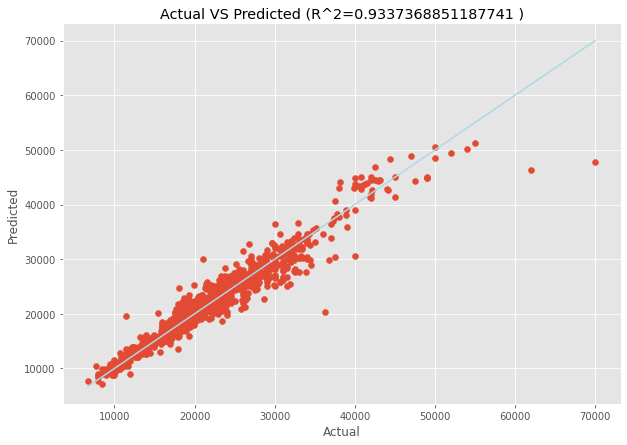

In [20]:
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from baselayer_azure_ml import ESMLTestScoringFactory

label = p.active_model["label"]
rmse, r2, mean_abs_percent_error,mae,spearman_corr,plt = ESMLTestScoringFactory(p).get_test_scoring_4_regression(label)
print("RMSE:")
print(rmse)
print()
print("R2:")
print(r2)
print()
print("MAPE:")
print(mean_abs_percent_error)
print()
print("MAE:")
print(mae)
print()
print("Spearman:")
print(spearman_corr)

# 3a) ESML `BATCH SCORING pipeline` in `4 lines of code` (CPU Clusters)

In [1]:
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from esml import ESMLProject
from baselayer_azure_ml_pipeline import ESMLPipelineFactory, esml_pipeline_types

p = ESMLProject()
p.inference_mode = True

p.ws = p.get_workspace_from_config() #2) Ensure workspace is set
p.active_model = 12 # Cars: 'price' as label for regression

p_factory = ESMLPipelineFactory(p)

##### PARAMETERS - Simulate dynamic parameters passed from Azure Datafactoy=Caller....such as "daily scoring" with a specific model_version
p_factory.batch_pipeline_parameters[0].default_value = 1 # 0 meaning latest model_version
scoring_date = '2021-06-08 10:35:01.243860'
p_factory.batch_pipeline_parameters[1].default_value = scoring_date # overrides ESMLProject.date_scoring_folder.
##### PARAMETERS end

p_factory.describe()

Using lake_settings.json with ESML version 1.4 - Models array support including LABEL


If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.



 ---- Q: WHICH files are generated as templates, for you to EDIT? ---- 
A: These files & locations:
File to EDIT (step: IN_2_SILVER_1): ../../../2_A_aml_pipeline/4_inference/batch/M12/in2silver_ds01_vw.py
File to EDIT (step: IN_2_SILVER_2): ../../../2_A_aml_pipeline/4_inference/batch/M12/in2silver_ds02_audi.py
File to EDIT (step: IN_2_SILVER_3): ../../../2_A_aml_pipeline/4_inference/batch/M12/in2silver_ds03_bmw.py
File to EDIT (step: SILVER_MERGED_2_GOLD): ../../../2_A_aml_pipeline/4_inference/batch/M12/silver_merged_2_gold.py
File to EDIT (step: SCORING_GOLD): ../../../2_A_aml_pipeline/4_inference/batch/M12/scoring_gold.py
File to EDIT a lot (reference in step-scripts Custom code): ../../../2_A_aml_pipeline/4_inference/batch/M12/your_code/your_custom_code.py

 ---- WHAT model to SCORE with, & WHAT data 'date_folder'? ---- 
InferenceModelVersion (model version to score with): 1
Date_scoring_folder (data to score) : 2021-06-08 10:35:01.243860
ESML environment: dev

 ---- ESML Datalake 

## How to: Ensure a traind model exists? 

In [2]:
model = p.get_best_model_via_experiment_name() # Ensure a "BEST MODEL exists, otherwise you need to train and register a model first"
print(model)
print(p_factory.p.ws)

found model via REMOTE FILTER: Experiment TAGS: model_name
Model(workspace=Workspace.create(name='msft-weu-DEV-eap-proj02_ai-amls', subscription_id='ca0a8c40-b06a-4e4e-8434-63c03a1dee34', resource_group='MSFT-WEU-EAP_PROJECT02_AI-DEV-RG'), name=AutoMLb608482be0, id=AutoMLb608482be0:6, version=6, tags={'run_id': 'AutoML_b608482b-eaf3-4398-b7f0-2b6001566e27', 'model_name': 'AutoMLb608482be0', 'trained_in_environment': 'dev', 'trained_in_workspace': 'msft-weu-DEV-eap-proj02_ai-amls', 'experiment_name': '12_car_price_regression'}, properties={})
Workspace.create(name='msft-weu-DEV-eap-proj02_ai-amls', subscription_id='ca0a8c40-b06a-4e4e-8434-63c03a1dee34', resource_group='MSFT-WEU-EAP_PROJECT02_AI-DEV-RG')


## NOW: Build pipeline automatically, run it, and publish it

In [4]:
## BUILD
p_factory.create_dataset_scripts_from_template(overwrite_if_exists=True) # Do this once, then edit them manually. overwrite_if_exists=False is DEFAULT
batch_pipeline = p_factory.create_batch_pipeline(esml_pipeline_types.IN_2_GOLD_SCORING) # Creates pipeline from template

Creates template step_files.py for user to edit at:
Edit at ../../../2_A_aml_pipeline/4_inference/batch/M12/in2silver_ds01_vw.py
Edit at ../../../2_A_aml_pipeline/4_inference/batch/M12/in2silver_ds02_audi.py
Edit at ../../../2_A_aml_pipeline/4_inference/batch/M12/in2silver_ds03_bmw.py
Edit at ../../../2_A_aml_pipeline/4_inference/batch/M12/silver_merged_2_gold.py
Edit at ../../../2_A_aml_pipeline/4_inference/batch/M12/scoring_gold.py
Edit at ../../../2_A_aml_pipeline/4_inference/batch/M12/your_code/your_custom_code.py
Using GEN2 as Datastore
debub-01: self.p.ws
Workspace.create(name='msft-weu-DEV-eap-proj02_ai-amls', subscription_id='ca0a8c40-b06a-4e4e-8434-63c03a1dee34', resource_group='MSFT-WEU-EAP_PROJECT02_AI-DEV-RG')
found model via REMOTE FILTER: Experiment TAGS: model_name
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Using a model specific 

In [22]:
## RUN
pipeline_run = p_factory.execute_pipeline(batch_pipeline)
pipeline_run.wait_for_completion(show_output=False)

Creates template step_files.py for user to edit at:
Edit at ../../../2_A_aml_pipeline/4_inference/batch/M12/in2silver_ds01_vw.py
Edit at ../../../2_A_aml_pipeline/4_inference/batch/M12/in2silver_ds02_audi.py
Edit at ../../../2_A_aml_pipeline/4_inference/batch/M12/in2silver_ds03_bmw.py
Edit at ../../../2_A_aml_pipeline/4_inference/batch/M12/silver_merged_2_gold.py
Edit at ../../../2_A_aml_pipeline/4_inference/batch/M12/scoring_gold.py
Edit at ../../../2_A_aml_pipeline/4_inference/batch/M12/your_code/your_custom_code.py
Using GEN2 as Datastore
found model via REMOTE FILTER: Experiment TAGS: model name and version
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Using a model specific cluster, per configuration in project specific settings, (the integer of 'model_number' is the base for the name)
Note: OVERRIDING enterprise performance settings with proj

'Finished'

In [ ]:
# When satisfied...running wihtout ERRORS, then PUBLISH:
published_pipeline, endpoint = p_factory.publish_pipeline(batch_pipeline) #, "_1") # "_4" is optional    to create a NEW pipeline with 0 history, not ADD version to existing pipe & endpoint

# 3b) ESML `Deploy model ONLINE` in `2 lines of code` (AKS) 
- Deploy "offline" MODEL from old `run` in environment To →  `DEV`, `TEST` or `PROD` environment
- ESML saves `API_key in Azure keyvault automatically`
- ESML auto-config solves 4 common 'errors/things': `correct compute name` and `valid replicas, valid agents, valid auto scaling`
    - Tip: You can adjust the number of replicas, and different CPU/memory configuration, or using a different compute target.

In [ ]:
p.dev_test_prod,p.ws.name

('dev', 'msft-weu-DEV-eap-proj02_ai-amls')

In [ ]:
inference_config, model, best_run = p.get_active_model_inference_config(p.ws) #  Get compute power & lib-dependecies for DOCKER...for correct (Dev,Test or Prod) environment.
service,api_uri, kv_aks_api_secret= p.deploy_automl_model_to_aks(model,inference_config,True) # True=Overwrite. Deploy: AKS dockerized with correct config (Dev,Test or Prod subscription & networking)

Loading AutoML config settings from: dev
Loading AutoML config settings from: dev
Package:azureml-automl-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-core, training version:1.30.0, current version:1.26.0
Package:azureml-dataprep, training version:2.15.1, current version:2.13.2
Package:azureml-dataprep-native, training version:33.0.0, current version:32.0.0
Package:azureml-dataprep-rslex, training version:1.13.0, current version:1.11.2
Package:azureml-dataset-runtime, training version:1.30.0, current version:1.26.0
Package:azureml-defaults, training version:1.30.0, current version:1.26.0
Package:azureml-interpret, training version:1.30.0, current version:1.26.0
Package:azureml-pipeline-core, training version:1.30.0, current version:1.26.0
Package:azureml-telemetry, training version:1.30.0, current version:1.26.0
Package:azureml-train-automl-client, training version:1.30.0, current version:1.26.0
Package:azureml-train-automl-runtime, training version:1.30.0, c

## 3b) ESML Test AKS webservice, `2 lines of code`

In [ ]:
p.inference_mode = False # We want "SCORING" mode

In [6]:
#p.connect_to_lake() # only needed if NOT p.init() is done
X_test, y_test, tags = p.get_gold_validate_Xy() # Get the X_test data, ESML knows the SPLIT and LABEL already (due to training)
print(tags)
caller_id = "91965d9c-40ca-4e47-9723-5a608a32a0e4"

df = p.call_webservice(p.ws, X_test,caller_id) # Auto-fetch key from keyvault, and calls the webservice
df.head()

Using GEN2 as Datastore
M03_GOLD_VALIDATE : (23, 11)
X_test  (23, 10)
y_test  (23,)
{'split_percentage': '0.2', 'label': 'Y', 'model': '03_diabetes_model_reg'}
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Note: Fetching keys automatically via workspace keyvault.
Saving scoring to lake for project folder project002 and inference_model_version: 1 ...
...

Saved DATA to score successfully in LAKE, as file 'to_score_91965d9c-40ca-4e47-9723-5a608a32a0e4.parquet'
Saved SCORED data in LAKE, as file 'scored_91965d9c-40ca-4e47-9723-5a608a32a0e4.parquet'


,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,result
0,0.081666,0.050680,-0.002973,-0.033214,0.042462,0.057871,-0.010266,0.034309,-0.000609,-0.001078,117.230116
1,0.045341,0.050680,0.060618,0.031053,0.028702,-0.047347,-0.054446,0.071210,0.133599,0.135612,235.206148
2,0.070769,-0.044642,-0.005128,-0.005671,0.087868,0.102965,0.011824,0.034309,-0.008944,0.027917,148.781108
3,0.052606,0.050680,-0.009439,0.049415,0.050717,-0.019163,-0.013948,0.034309,0.119344,-0.017646,179.976727
4,0.045341,0.050680,-0.008362,-0.033214,-0.007073,0.001191,-0.039719,0.034309,0.029936,0.027917,190.217620


# From "OFFILINE": Test Scoring, without train, deploy, or ESMLProject.init()

In [1]:
import repackage
repackage.add("../azure-enterprise-scale-ml/esml/common/")
from esml import ESMLDataset, ESMLProject

p = ESMLProject() # Will search in ROOT for your copied SETTINGS folder '../../../settings', you should copy template settings from '../settings'
p.inference_mode = True # We want "TRAIN" mode
p.ws = p.get_workspace_from_config() #2) Load DEV or TEST or PROD Azure ML Studio workspace

label = "Y"
to_score = None
try:
    X_test = p.GoldTest.to_pandas_dataframe()
    to_score = X_test.drop([label], axis=1)
    print(to_score.head()) # gold_test_1 = Dataset.get_by_name(ws, name=p.dataset_gold_test_name_azure)
except: 
    print ("you need to have splitted GOLD dataset, GoldTest need to exist. Change next cell from MARKDOWN, to CODE, and run that. Try this again... ")

        AGE       SEX       BMI        BP        S1        S2        S3  \
0  0.041708 -0.044642 -0.007284  0.028758 -0.042848 -0.048286  0.052322   
1  0.059871  0.050680  0.022895  0.049415  0.016318  0.011838 -0.013948   
2  0.041708  0.050680  0.071397  0.008101  0.038334  0.015909 -0.017629   
3  0.041708  0.050680  0.012117  0.039087  0.054845  0.044406  0.004460   
4  0.034443  0.050680  0.028284 -0.033214 -0.045599 -0.009769 -0.050764   

         S4        S5        S6  
0 -0.076395 -0.072128  0.023775  
1 -0.002592  0.039540  0.019633  
2  0.034309  0.073410  0.085907  
3 -0.002592  0.045601 -0.001078  
4 -0.002592 -0.059473 -0.021788  


In [2]:
p.connect_to_lake() # only needed if NOT p.init() is done
caller_id = "91965d9c-40ca-4e47-9723-5a608a32a0e4"
df = p.call_webservice(p.ws, to_score,caller_id) # Auto-fetch key from keyvault, and calls the webservice
df.head()

Using GEN2 as Datastore
Note: OVERRIDING enterprise performance settings with project specifics. (to change, set flag in 'dev_test_prod_settings.json' -> override_enterprise_settings_with_model_specific=False)
Note: Fetching keys automatically via workspace keyvault.
Saving scoring to lake for project folder project002 and inference_model_version: 1 ...
...

Saved DATA to score successfully in LAKE, as file 'to_score_91965d9c-40ca-4e47-9723-5a608a32a0e4.parquet'
Saved SCORED data in LAKE, as file 'scored_91965d9c-40ca-4e47-9723-5a608a32a0e4.parquet'


,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,result
0,0.041708,-0.044642,-0.007284,0.028758,-0.042848,-0.048286,0.052322,-0.076395,-0.072128,0.023775,154.320413
1,0.059871,0.050680,0.022895,0.049415,0.016318,0.011838,-0.013948,-0.002592,0.039540,0.019633,226.793287
2,0.041708,0.050680,0.071397,0.008101,0.038334,0.015909,-0.017629,0.034309,0.073410,0.085907,280.466728
3,0.041708,0.050680,0.012117,0.039087,0.054845,0.044406,0.004460,-0.002592,0.045601,-0.001078,174.478831
4,0.034443,0.050680,0.028284,-0.033214,-0.045599,-0.009769,-0.050764,-0.002592,-0.059473,-0.021788,183.854316


# END